In [35]:
from lcapy import L,C,R
import lcapy
import sympy as sp
import numpy as np
from scipy.constants import e,pi,h
from sympy.core.mul import Mul,Pow,Add

In [2]:
class Bbox(object):
    def __init__(self, circuit, L_J = "L_J"):
        self.circuit = circuit
        self.L_J = L_J
        cir = self.circuit
        
        w = sp.Symbol('w',real=True)
        Yw = cir.Y.subs({sp.Symbol('s'):Mul(sp.I,w)})
        dY = sp.diff(Yw,sp.Symbol('w'))

        self.ws = []
        self.ks = []
        self.As = []
        self.N_modes = 0
        zeros = cir.Y.zeros()
        for w in zeros:
            w_num = complex(w.evalf(subs={i:1. for i in w.free_symbols}))
            if np.imag(w_num)>0:
                self.N_modes += 1
                self.ws.append(sp.functions.im(w))
                self.ks.append(-sp.functions.re(w))
                self.As.append(2.*e**2/h*Mul(1/sp.Symbol(L_J),Mul(Pow(1/sp.functions.im(dY.subs({sp.Symbol('w'):sp.functions.im(w)})),2),Pow(1/sp.functions.im(w),2))))



    
    def fkA(self,circuit_parameters):
        circuit_parameters['j'] = 1j
        to_return = []
        for param in [self.ws,self.ks,self.As]:
            N_param = sp.utilities.lambdify([key for key in circuit_parameters],param,"numpy")
            to_return.append(N_param(*[circuit_parameters[key] for key in circuit_parameters]))
        return [np.array(to_return[0])/2./pi,np.array(to_return[1])/2./pi,to_return[2]]

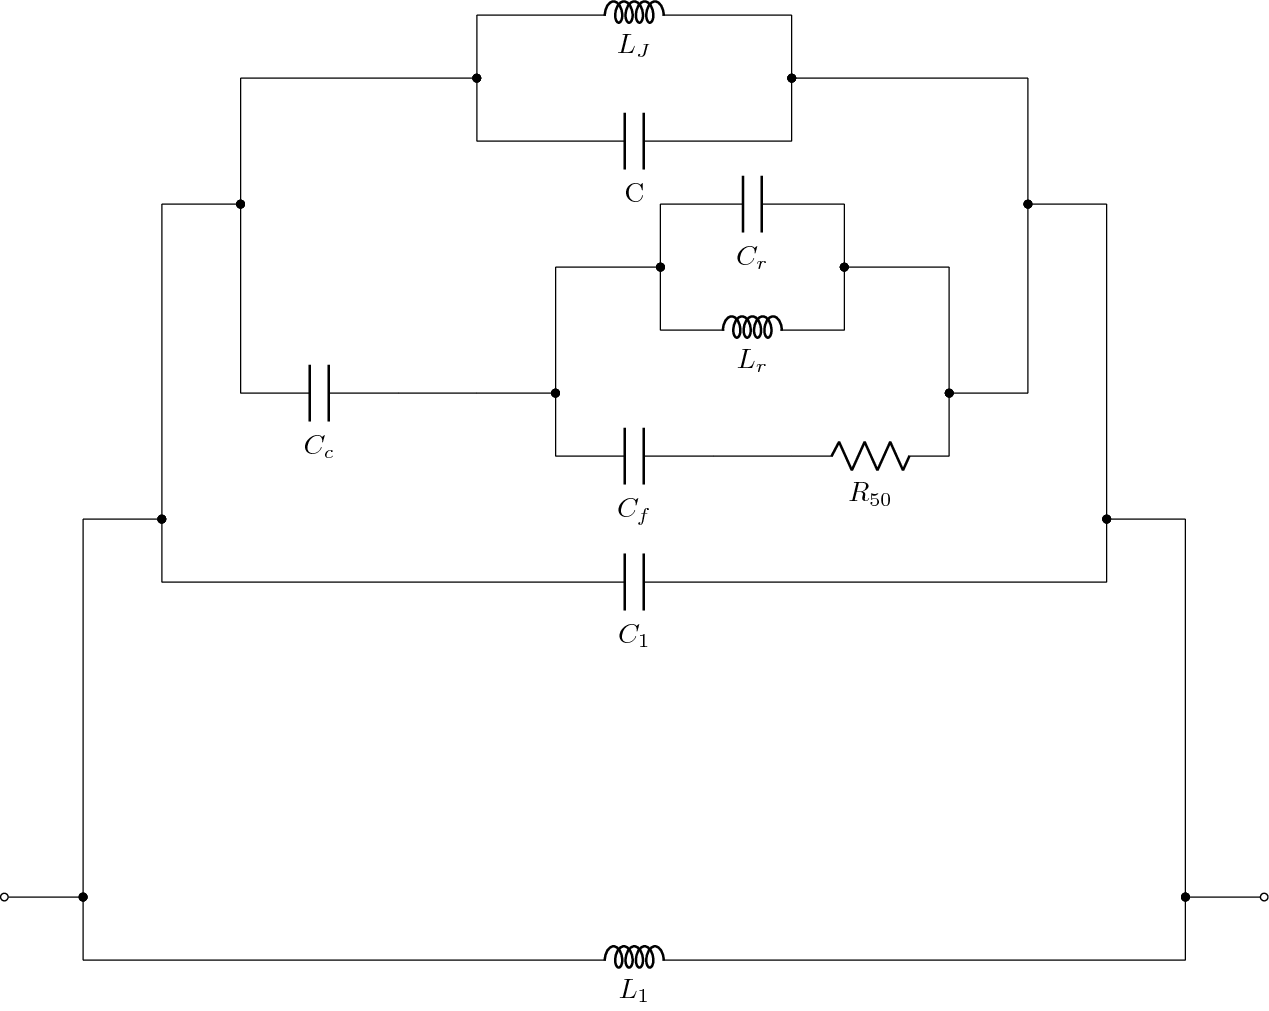

Wall time: 3.57 s


In [116]:
%%time
circuit = L('L_J') | C('C') | (C('Cc')+(C('Cr')|L('Lr')|(C('C_f')+R('R_50'))))|C('C_1')|L('L_1')
# circuit = L('L') | C('C')
drawing = circuit.draw()

In [94]:
def admittance(circuit):
    if type(circuit) == lcapy.oneport.Par:
        return Add(admittance(circuit.args[0]),admittance(circuit.args[1]))
    elif type(circuit) == lcapy.oneport.Ser:
        return 1/Add(1/admittance(circuit.args[0]),1/admittance(circuit.args[1]))
    elif type(circuit) == lcapy.oneport.L:
        return -sp.I*Mul(1/sp.Symbol('\omega'),1/sp.Symbol(circuit.args[0],real=True))
    elif type(circuit) == lcapy.oneport.C:
        return sp.I*Mul(sp.Symbol('\omega'),sp.Symbol(circuit.args[0],real=True))
    elif type(circuit) == lcapy.oneport.R:
        return 1/sp.Symbol(circuit.args[0],real=True)

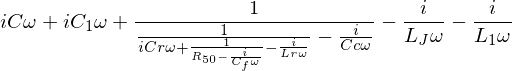

In [95]:
Y = admittance(circuit)
Y

In [108]:
Y_numer = sp.numer(sp.together(Y))
Y_numer

In [107]:
sp.solve(Y_numer,sp.Symbol('\omega'))

In [96]:
sp.solve(Y,sp.Symbol('\omega'))

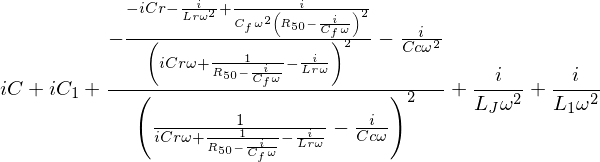

In [97]:
sp.diff(Y,sp.Symbol('\omega'))

In [112]:
Y_poly = sp.collect(sp.expand(Y_numer),sp.Symbol('\omega'))

In [115]:
Y_order = sp.polys.polytools.degree(Y_poly,gen = sp.Symbol('\omega'))